# MNIST Digit Classification Using CNN Neural Network in PyTorch

This project implements a Convolutional Neural Network (CNN) using PyTorch for classifying MNIST digits. The CNN is trained on a dataset with 60,000 images and has been evaluated to achieve an accuracy of 96.5% on unseen data and an accuracy of 97% on seen data.

In [11]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preprocess Data
This is a function named processData that takes a batch size as an argument. The function reads the MNIST training and test data from CSV files using Pandas, then converts the data into PyTorch tensors and reshapes them into the appropriate dimensions for the convolutional neural network (CNN) model.

In [12]:
def processData(batch_size):
    train_data = pd.read_csv('mnist_train.csv').sample(frac = 1).reset_index(drop = True)
    test_data = pd.read_csv('mnist_test.csv')

    train_data_labels = torch.tensor(train_data.iloc[:, 0].values).reshape(-1, 1).to(device)
    train_data = torch.tensor(train_data.iloc[:, 1:].values).reshape(-1, 1, 28, 28).to(device) / 255

    test_data_labels = torch.tensor(test_data.iloc[:, 0].values).reshape(-1, 1).to(device)
    test_data = torch.tensor(test_data.iloc[:, 1:].values).reshape(-1, 1, 28, 28).to(device) / 255

    train_data = DataLoader(dataset = TensorDataset(train_data, train_data_labels), batch_size = batch_size, shuffle = False)
    test_data = DataLoader(dataset = TensorDataset(test_data, test_data_labels), batch_size = batch_size, shuffle = False)

    return train_data, test_data

## Draw Images
This is a function named drawImage that takes a list of images as input. Each image is a tuple of three elements: the first element is the image tensor, the second element is the predicted label for the image, and the third element is the actual label for the image.

In [13]:
def drawImage(images):
    for image in images: 
        number = np.squeeze(image[0]).reshape(28, 28, 1)
        plt.imshow(number)
        plt.title(f"Predicted {image[1].item()} Actual: {image[2].item()}")
        plt.show()

## Neural Network Architecture

The neural network architecture is defined in the MNISTCNN class. The class takes the following arguments during initialization:

- channels: Number of input channels (1 for grayscale images).
- output_classes: Number of output classes (10 for MNIST digits).
- kernel_size: Size of convolutional kernel.
- cnn_hidden_layers: List of integers specifying the sizes of the convolutional hidden layers.
- ann_hidden_layers: List of integers specifying the sizes of the feed-forward hidden hidden layers.

The neural network has the following architecture:

- Convolutional layer with 64 output channels, kernel size of 9, stride of 1, and padding of 1.
- Max pooling layer with kernel size of 2
- onvolutional layer with 128 output channels, kernel size of 9, stride of 1, and padding of 1.
- Fully connected layer with 500 output neurons.
- Fully connected layer with 100 output neurons.
- Output layer with 10 output neurons (one for each digit).

In [22]:
class MNISTCNN(nn.Module):

    def __init__(self, channels, kernel_size, cnn_layers, ann_layers, output_size):
        super().__init__()  

        self.input_layer = nn.Conv2d(channels, cnn_layers[0], kernel_size = kernel_size[0]).to(device)
        self.pool = nn.MaxPool2d(kernel_size = 2).to(device)
        ann_input = (28 - kernel_size[0] + 1) / 2
        self.cnn_layers = []
        self.ann_layers = []
        self.accuracy = {}
        
        for i in range(len(cnn_layers) - 1): 
            ann_input = int(np.floor((ann_input - kernel_size[i + 1] + 1) / 2))
            self.cnn_layers.append(nn.Conv2d(cnn_layers[i], cnn_layers[i + 1], kernel_size = kernel_size[i + 1]).to(device))

        self.final_cnn_pixels = ann_input
        ann_input = cnn_layers[-1] * ann_input ** 2
        self.ann_layers.append(nn.Linear(ann_input, ann_layers[0]).to(device))

        for i in range(len(ann_layers) - 1): self.ann_layers.append(nn.Linear(ann_layers[i], ann_layers[i + 1]).to(device))
        self.output_layer = nn.Linear(ann_layers[-1], output_size).to(device)
    
    def forward(self, input):
        x = self.pool(torch.relu(self.input_layer(input)).to(device))
        ann_inputs = self.cnn_layers[-1].out_channels * self.final_cnn_pixels ** 2 
        
        for layer in self.cnn_layers: x = self.pool(torch.relu(layer(x)).to(device))
        x = x.reshape(-1, ann_inputs)
        for layer in self.ann_layers: x = torch.relu(layer(x)).to(device)
        
        output = torch.sigmoid(self.output_layer(x))
        return output
    
    def trainNetwork(self, dataloader, optimiser, criterion, epochs):
        for epoch in range(epochs):
            training_loss = 0 

            for (X, y) in dataloader:
                self.train()
                optimiser.zero_grad()
                predictions = self.forward(X).to(device)
                loss = criterion(predictions, y.squeeze().long())
                training_loss += loss
                loss.backward()
                optimiser.step()

            if epoch % 2 == 0: 
                training_loss /= len(dataloader)
                accuracy = self.getAccuracy(dataloader)
                self.accuracy[epoch] = accuracy.cpu().item()
                print(f"Epoch: {epoch} Loss: {training_loss} Accuracy: {accuracy}")
    
    def getAccuracy(self, dataloader):
        self.eval()
        correct = 0  

        for (data, labels) in dataloader: 
            predictions = self.forward(data).to(device)  
            true_false_predictions = predictions.argmax(dim=1) == labels.squeeze().long().to(device)
            correct += (true_false_predictions).sum()
        return correct / len(dataloader.dataset)  
    
    def wrongPredictions(self, dataloader, image_amount):
        self.eval()
        images = []

        for (data, labels) in dataloader:  
            predictions = self.forward(data).to(device) 
            model_num_predictions = predictions.argmax(dim=1)
            true_false_predictions = predictions.argmax(dim=1) == labels.squeeze().long().to(device)
            false_predictions = torch.nonzero(~true_false_predictions).cpu().tolist()

            for index in false_predictions:
                images.append([data[index].cpu().numpy(), model_num_predictions[index].cpu().numpy(), labels[index].cpu().numpy()])
                if len(images) >= image_amount: return images
    
    def correctPredictions(self, dataloader, image_amount):
        self.eval()
        images = []

        for (data, labels) in dataloader:  
            predictions = self.forward(data).to(device) 
            model_num_predictions = predictions.argmax(dim=1)
            true_false_predictions = predictions.argmax(dim=1) == labels.squeeze().long().to(device)
            false_predictions = torch.nonzero(true_false_predictions).cpu().tolist()

            for index in false_predictions:
                images.append([data[index].cpu().numpy(), model_num_predictions[index].cpu().numpy(), labels[index].cpu().numpy()])
                if len(images) >= image_amount: return images
    
    def plotAccuracy(self):
        epochs = list(self.accuracy.keys())
        accuracy = list(self.accuracy.values())

        plt.plot(epochs, accuracy)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Epochs')
        plt.show()

    def saveModel(self, filename, optimiser):
        self.eval()
        torch.save({'model_state_dict': self.state_dict(), 'optimiser_state_dict': optimiser.state_dict()}, f'{filename}.pth')

## Initialise Model
These lines of code define a convolutional neural network (CNN) model using the MNISTCNN class.

The processData() function is used to load and preprocess the MNIST dataset, and it returns two DataLoader objects for training and testing.

The Adam optimiser is used with a learning rate of 0.05, and the cross-entropy loss is used as the loss function.

In [23]:
model = MNISTCNN(channels = 1, kernel_size = [9, 9], cnn_layers = [64, 128], ann_layers = [500, 100], output_size = 10)
train_data, test_data = processData(batch_size = 10000)

optimiser = optim.Adam(model.parameters(), lr = 0.05)
criterion = nn.CrossEntropyLoss()

## Training and analysing model 
The trainNetwork method of the MNISTCNN class trains the model on the specified data and prints the loss and accuracy after every 2 epochs. The getAccuracy method calculates the accuracy of the model on the specified data. The wrongPredictions method returns a list of images on which the model made incorrect predictions. correctPredictions similarly returns a handful of correct predictions by the model.The drawImage function can then be used to display these images. The plotAccuracy method of the MNISTCNN class plots the accuracy of the model during training. Finally, the saveModel method can be used to save the trained model and optimizer state to a file.

Epoch: 0 Loss: 1.503779649734497 Accuracy: 0.9596500396728516
Epoch: 2 Loss: 1.5024642944335938 Accuracy: 0.9608166813850403
Epoch: 4 Loss: 1.5013573169708252 Accuracy: 0.9617500305175781
Epoch: 6 Loss: 1.5002144575119019 Accuracy: 0.9617666602134705
Epoch: 8 Loss: 1.4990476369857788 Accuracy: 0.9629499912261963
Epoch: 10 Loss: 1.4976768493652344 Accuracy: 0.9643000364303589
Epoch: 12 Loss: 1.496880054473877 Accuracy: 0.9645333290100098
Epoch: 14 Loss: 1.495819091796875 Accuracy: 0.9654000401496887
Epoch: 16 Loss: 1.4949520826339722 Accuracy: 0.966533362865448
Epoch: 18 Loss: 1.4947326183319092 Accuracy: 0.9669333696365356
Epoch: 20 Loss: 1.4934738874435425 Accuracy: 0.9677333235740662
Epoch: 22 Loss: 1.492600440979004 Accuracy: 0.9684666991233826
Epoch: 24 Loss: 1.4919952154159546 Accuracy: 0.9690499901771545
Epoch: 26 Loss: 1.4917176961898804 Accuracy: 0.968416690826416
Epoch: 28 Loss: 1.4915730953216553 Accuracy: 0.9680666923522949
Epoch: 30 Loss: 1.4909056425094604 Accuracy: 0.9696

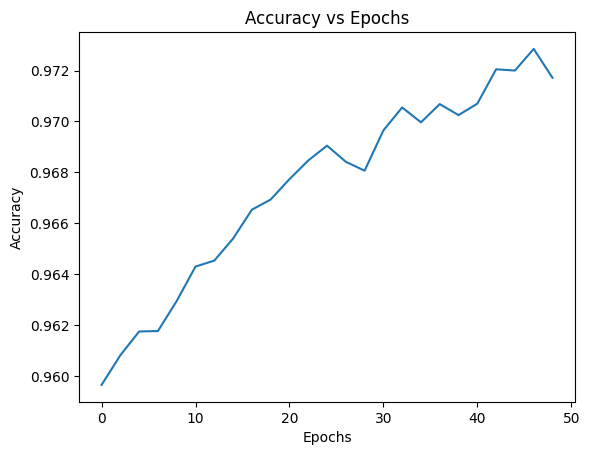

In [29]:
model.trainNetwork(dataloader = train_data, optimiser = optimiser, criterion = criterion, epochs = 50)
print(f"Accuracy on unseen data: {model.getAccuracy(test_data)}")

model.plotAccuracy()

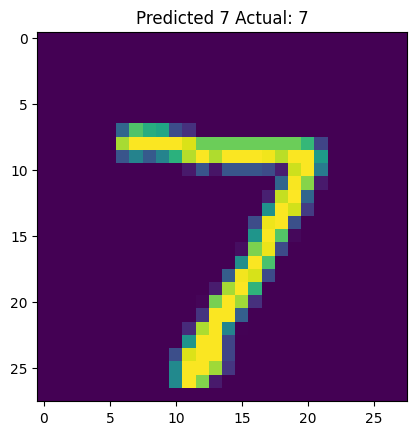

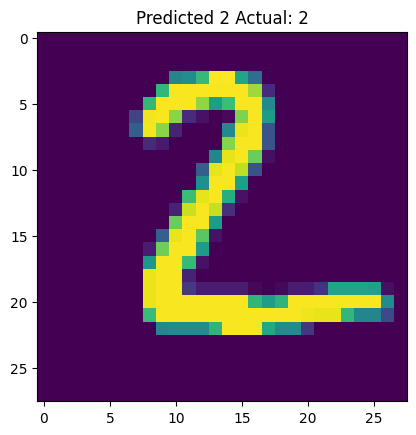

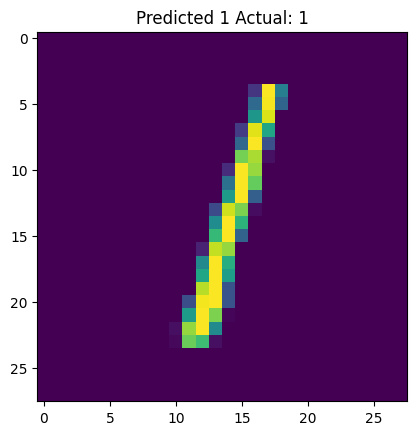

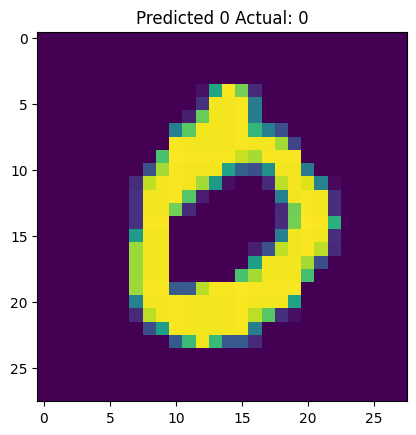

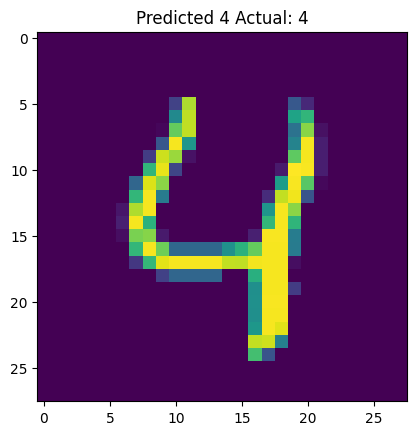

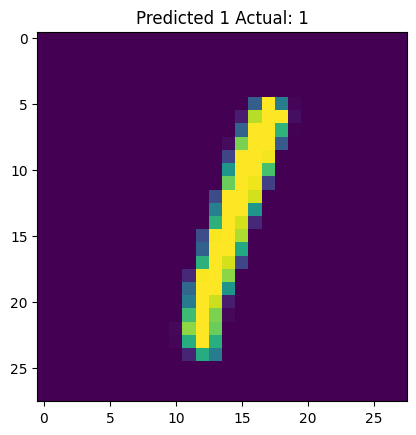

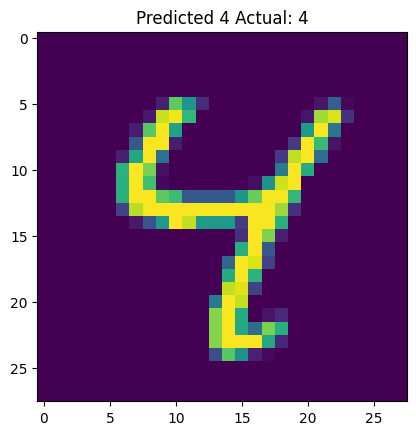

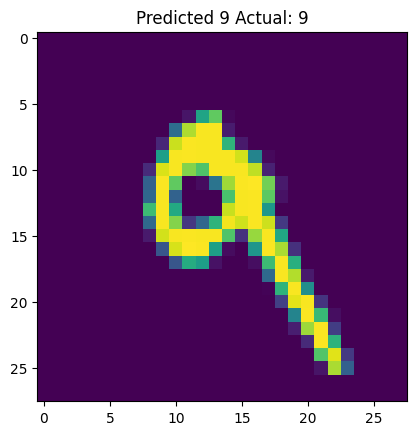

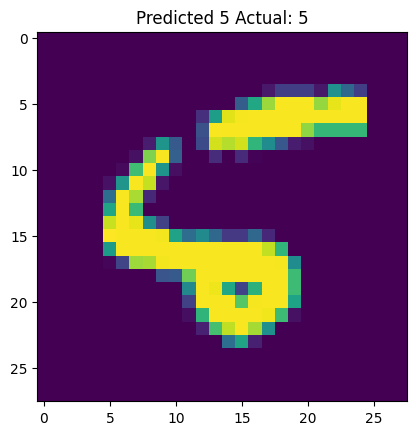

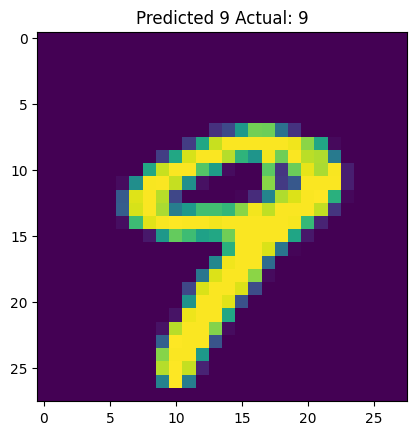

In [30]:
drawImage(model.correctPredictions(test_data, 10))

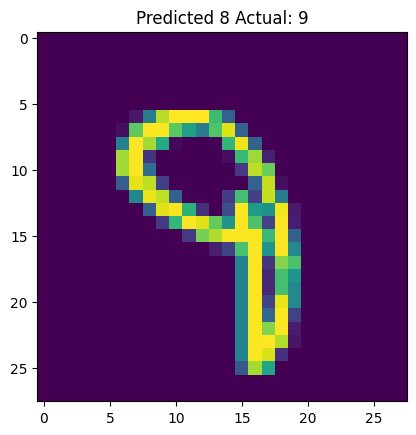

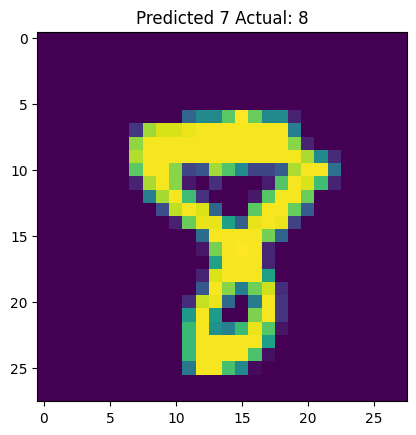

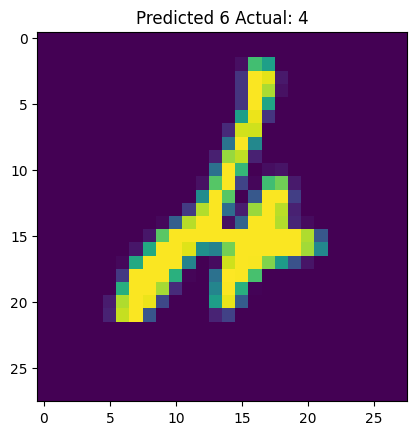

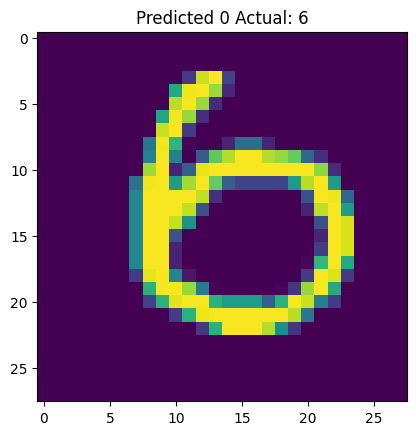

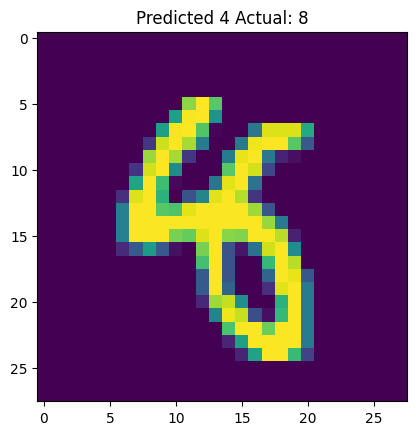

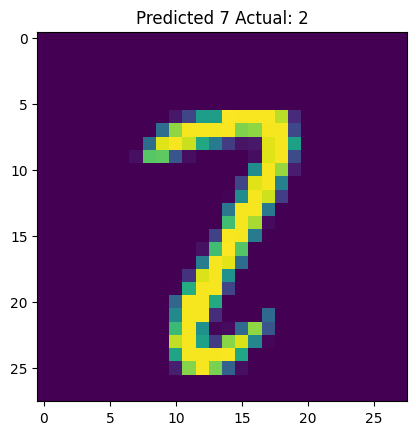

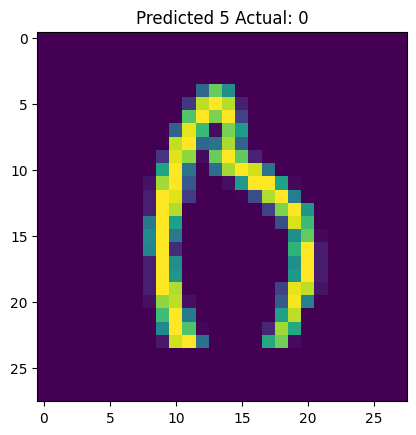

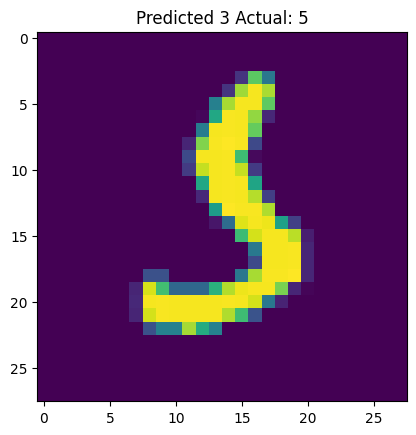

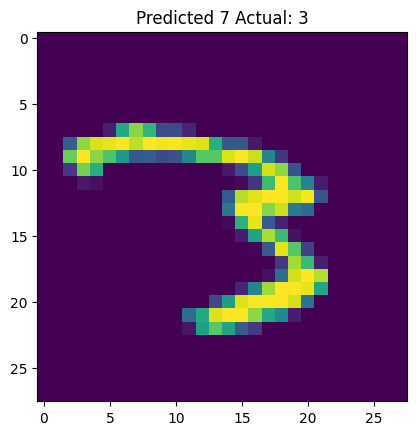

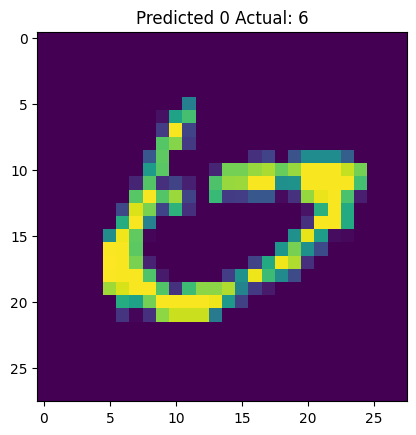

In [31]:
drawImage(model.wrongPredictions(test_data, 10))
model.saveModel(filename = 'model_checkpoint', optimiser = optimiser)

## Results 

The CNN network trained on the MNIST dataset achieved impressive results, with a 97% accuracy on the training dataset and a 96.7% accuracy on the test dataset. These results demonstrate that the model was able to generalize well and did not suffer from overfitting.